In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv('data/obecity_prediction.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

# Display first few rows
print("\nFirst few rows of the dataset:")
df.head()

Dataset Shape: (2111, 17)

Data Types:
 Gender             object
Age               float64
Height            float64
Weight            float64
family_history     object
FAVC               object
FCVC              float64
NCP               float64
CAEC               object
SMOKE              object
CH2O              float64
SCC                object
FAF               float64
TUE               float64
CALC               object
MTRANS             object
Obesity            object
dtype: object

Missing Values:
 Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64

First few rows of the dataset:


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


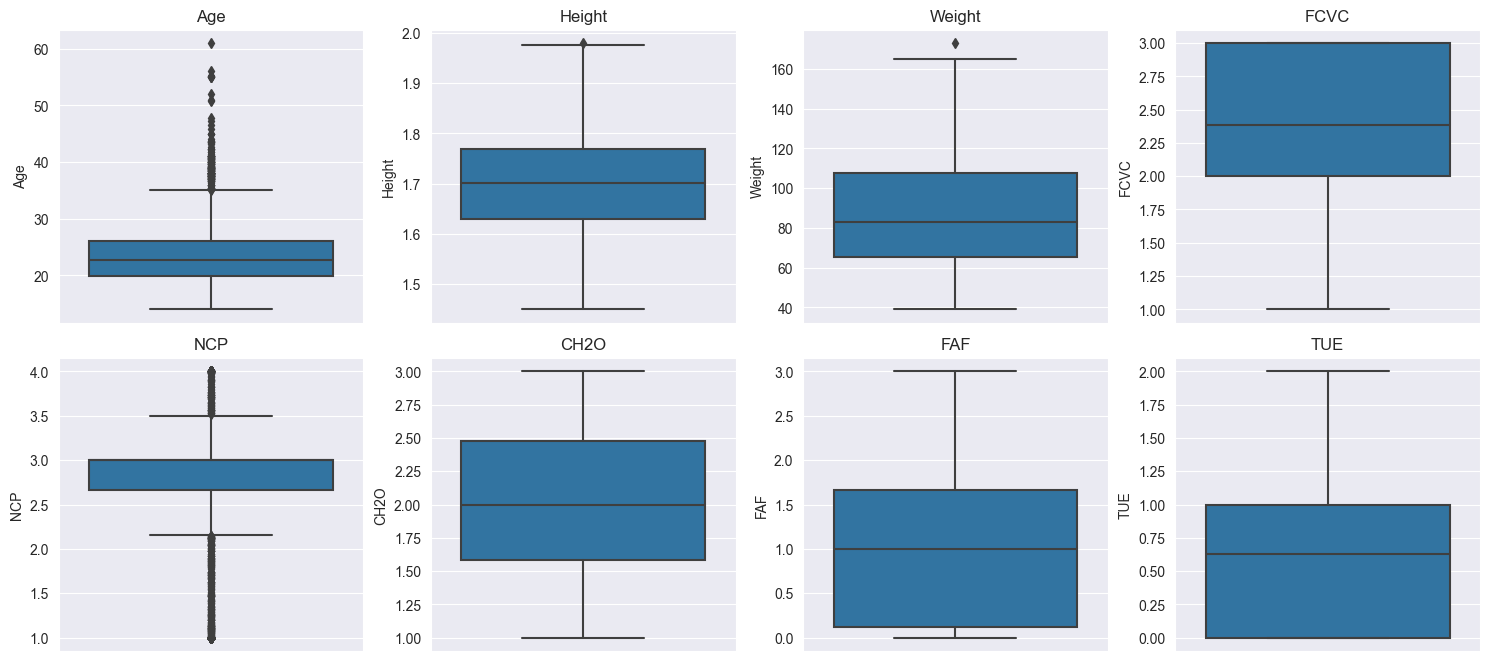

In [4]:
# Check outliers in numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df, y=feature)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [5]:
# Remove outliers for age (keep age <= 50)
df = df[df['Age'] <= 50]

In [6]:
# FCVC: round to integer value, categorical
df['FCVC'] = df['FCVC'].round().astype(int)
# CH2O: round to integer value, categorical
df['CH2O'] = df['CH2O'].round().astype(int)
# FAF: round to integer value, categorical
df['FAF'] = df['FAF'].round().astype(int)
# TUE: round to integer value, categorical
df['TUE'] = df['TUE'].round().astype(int)

In [7]:
# Create BMI feature
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Encode categorical variables
le = LabelEncoder()
categorical_columns = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'Obesity']

for column in categorical_columns:
    df[column + '_encoded'] = le.fit_transform(df[column])

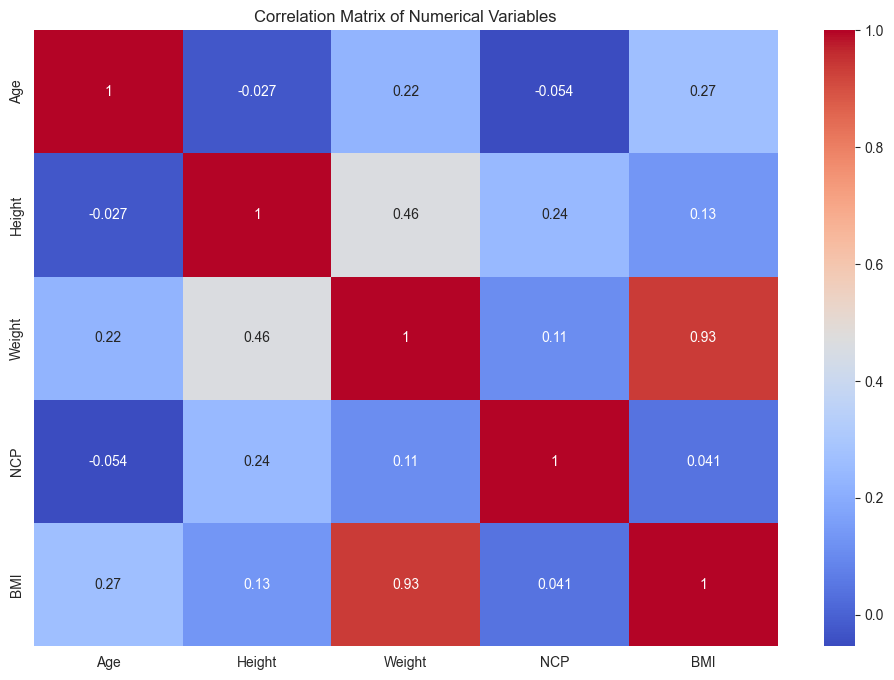

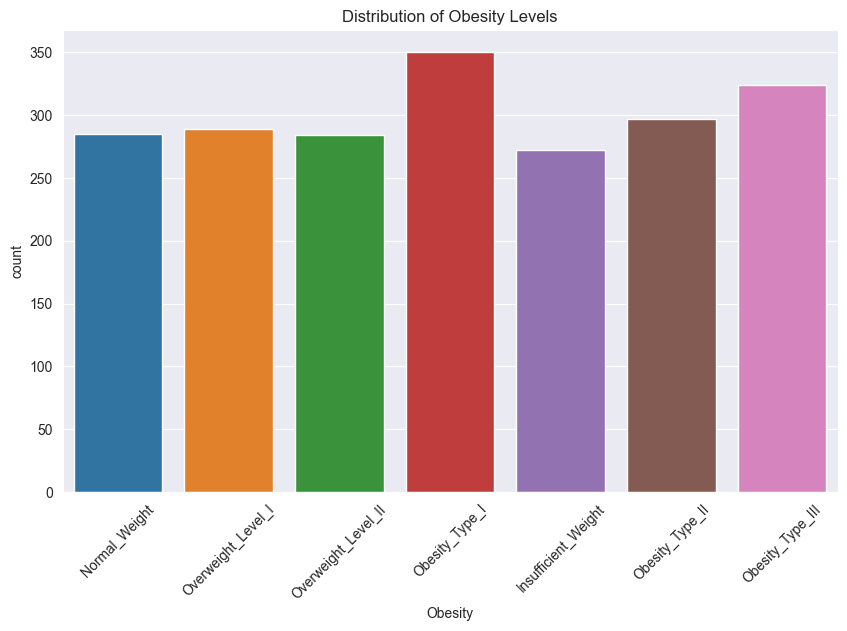

In [8]:
# Correlation matrix for numerical variables
numerical_columns = df.select_dtypes(include=['float64']).columns
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Distribution of obesity levels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Obesity')
plt.xticks(rotation=45)
plt.title('Distribution of Obesity Levels')
plt.show()

In [9]:
# Select features for the model
feature_columns = [col for col in df.columns if col.endswith('_encoded') and col != 'Obesity_encoded']
feature_columns.extend(['BMI',
                        'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'])

X = df[feature_columns]
y = df['Obesity_encoded']

# Split the data with 60:20:20 ratio (train:validation:test)
# First split: 80% train+validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Second split: 75% train (60% of total), 25% validation (20% of total)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Perform grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# Evaluate on validation set
y_val_pred = grid_search.predict(X_val_scaled)
print("Validation Score:", grid_search.score(X_val_scaled, y_val))

Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-validation Score: 0.9899641750789527
Validation Score: 0.9827989977352949



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        55
           1       0.96      1.00      0.98        64
           2       1.00      1.00      1.00        73
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        61
           5       1.00      0.98      0.99        54
           6       1.00      1.00      1.00        64

    accuracy                           0.99       421
   macro avg       0.99      0.99      0.99       421
weighted avg       0.99      0.99      0.99       421


AUC Score on Test Set: 0.9999

False Negative Rate by Class:
Class 0: 0.0364
Class 1: 0.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0185
Class 6: 0.0000


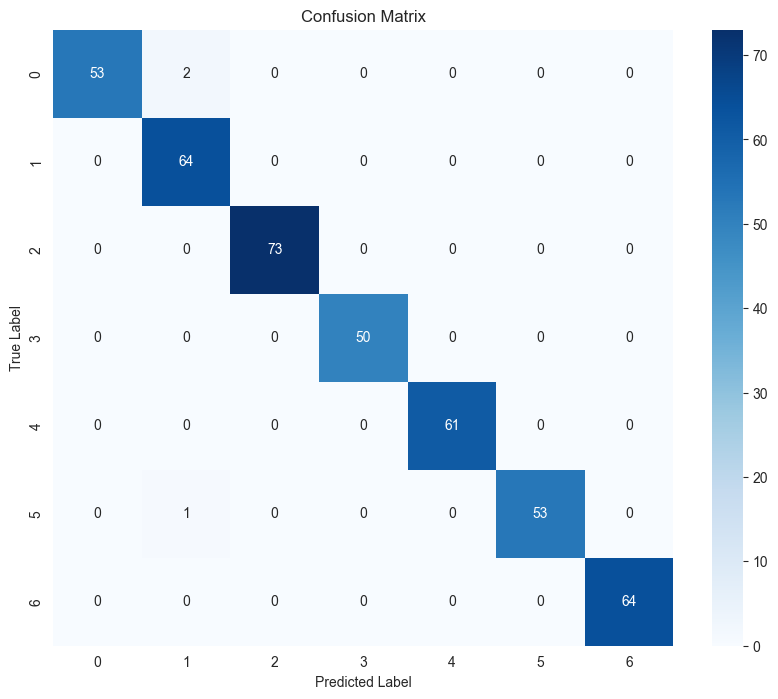

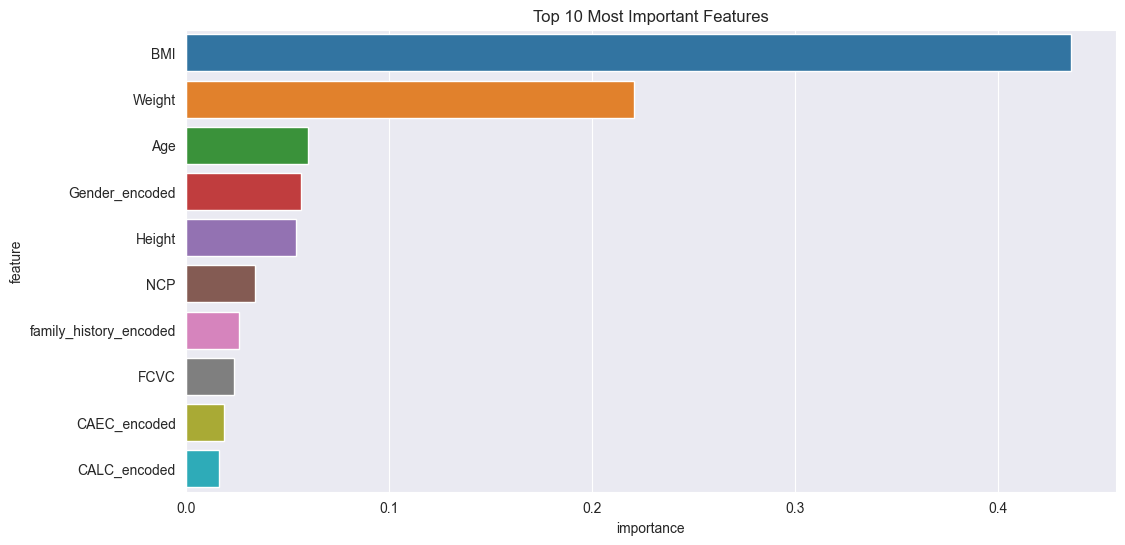

In [11]:
# Make predictions
y_test_pred = grid_search.predict(X_test_scaled)
y_test_prob = grid_search.predict_proba(X_test_scaled)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Calculate and display AUC (multiclass)
auc_score = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
print(f"\nAUC Score on Test Set: {auc_score:.4f}")

# Calculate false negative rate
cm = confusion_matrix(y_test, y_test_pred)
fn = cm.sum(axis=1) - np.diag(cm)
total_positives = cm.sum(axis=1)
fnr = fn / total_positives
print(f"\nFalse Negative Rate by Class:")
for i, rate in enumerate(fnr):
    print(f"Class {i}: {rate:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': grid_search.best_estimator_.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.show()

In [12]:
# Calculate and display additional metrics for all datasets
print("Model Performance Summary:")
print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Training Score: {grid_search.score(X_train_scaled, y_train):.4f}")
print(f"Validation Score: {grid_search.score(X_val_scaled, y_val):.4f}")
print(f"Testing Score: {grid_search.score(X_test_scaled, y_test):.4f}")

# Calculate AUC for all datasets
train_prob = grid_search.predict_proba(X_train_scaled)
val_prob = grid_search.predict_proba(X_val_scaled)
test_prob = grid_search.predict_proba(X_test_scaled)

train_auc = roc_auc_score(y_train, train_prob, multi_class='ovr')
val_auc = roc_auc_score(y_val, val_prob, multi_class='ovr')
test_auc = roc_auc_score(y_test, test_prob, multi_class='ovr')

print(f"\nAUC Scores:")
print(f"Training AUC: {train_auc:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Testing AUC: {test_auc:.4f}")

# Calculate false negative rates for all datasets
y_train_pred = grid_search.predict(X_train_scaled)
y_val_pred = grid_search.predict(X_val_scaled)
y_test_pred = grid_search.predict(X_test_scaled)

# Training FNR
train_cm = confusion_matrix(y_train, y_train_pred)
train_fn = train_cm.sum(axis=1) - np.diag(train_cm)
train_total_positives = train_cm.sum(axis=1)
train_fnr = train_fn / train_total_positives
train_avg_fnr = train_fn.sum() / train_total_positives.sum()

# Validation FNR
val_cm = confusion_matrix(y_val, y_val_pred)
val_fn = val_cm.sum(axis=1) - np.diag(val_cm)
val_total_positives = val_cm.sum(axis=1)
val_fnr = val_fn / val_total_positives
val_avg_fnr = val_fn.sum() / val_total_positives.sum()

# Test FNR
test_cm = confusion_matrix(y_test, y_test_pred)
test_fn = test_cm.sum(axis=1) - np.diag(test_cm)
test_total_positives = test_cm.sum(axis=1)
test_fnr = test_fn / test_total_positives
test_avg_fnr = test_fn.sum() / test_total_positives.sum()

print(f"\nFalse Negative Rates:")
print(f"Training Average FNR: {train_avg_fnr:.4f}")
print(f"Validation Average FNR: {val_avg_fnr:.4f}")
print(f"Testing Average FNR: {test_avg_fnr:.4f}")

# Display top 5 most important features
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

Model Performance Summary:
Best Model Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training Score: 1.0000
Validation Score: 0.9828
Testing Score: 0.9922

AUC Scores:
Training AUC: 1.0000
Validation AUC: 0.9999
Testing AUC: 0.9999

False Negative Rates:
Training Average FNR: 0.0000
Validation Average FNR: 0.0167
Testing Average FNR: 0.0071

Top 5 Most Important Features:
           feature  importance
8              BMI    0.436261
11          Weight    0.220828
9              Age    0.060034
0   Gender_encoded    0.056972
10          Height    0.054352



Comprehensive Model Evaluation Metrics:
Accuracy: 0.9929
F1 Score (weighted): 0.9929
True Positive Rate (Recall, weighted): 0.9929
True Negative Rate (Specificity, average): 0.9988
AUC Score: 0.9999

Performance Metrics Across All Datasets:
Metric                    Training        Validation      Testing        
----------------------------------------------------------------------
Accuracy                  1.0000          0.9833          0.9929         
F1 Score (weighted)       1.0000          0.9833          0.9929         
True Positive Rate        1.0000          0.9833          0.9929         
True Negative Rate        1.0000          0.9972          0.9988         
AUC Score                 1.0000          0.9999          0.9999         
False Negative Rate       0.0000          0.0167          0.0071         

Per-Class Metrics on Test Set:
Class      Precision       Recall (TPR)    F1 Score        TNR             FNR            
----------------------------------------------

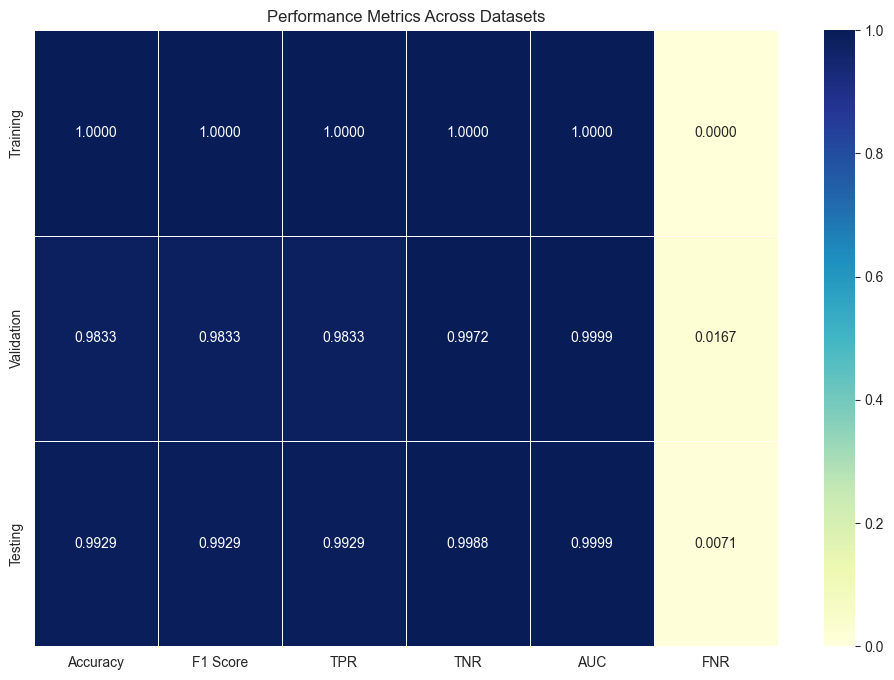

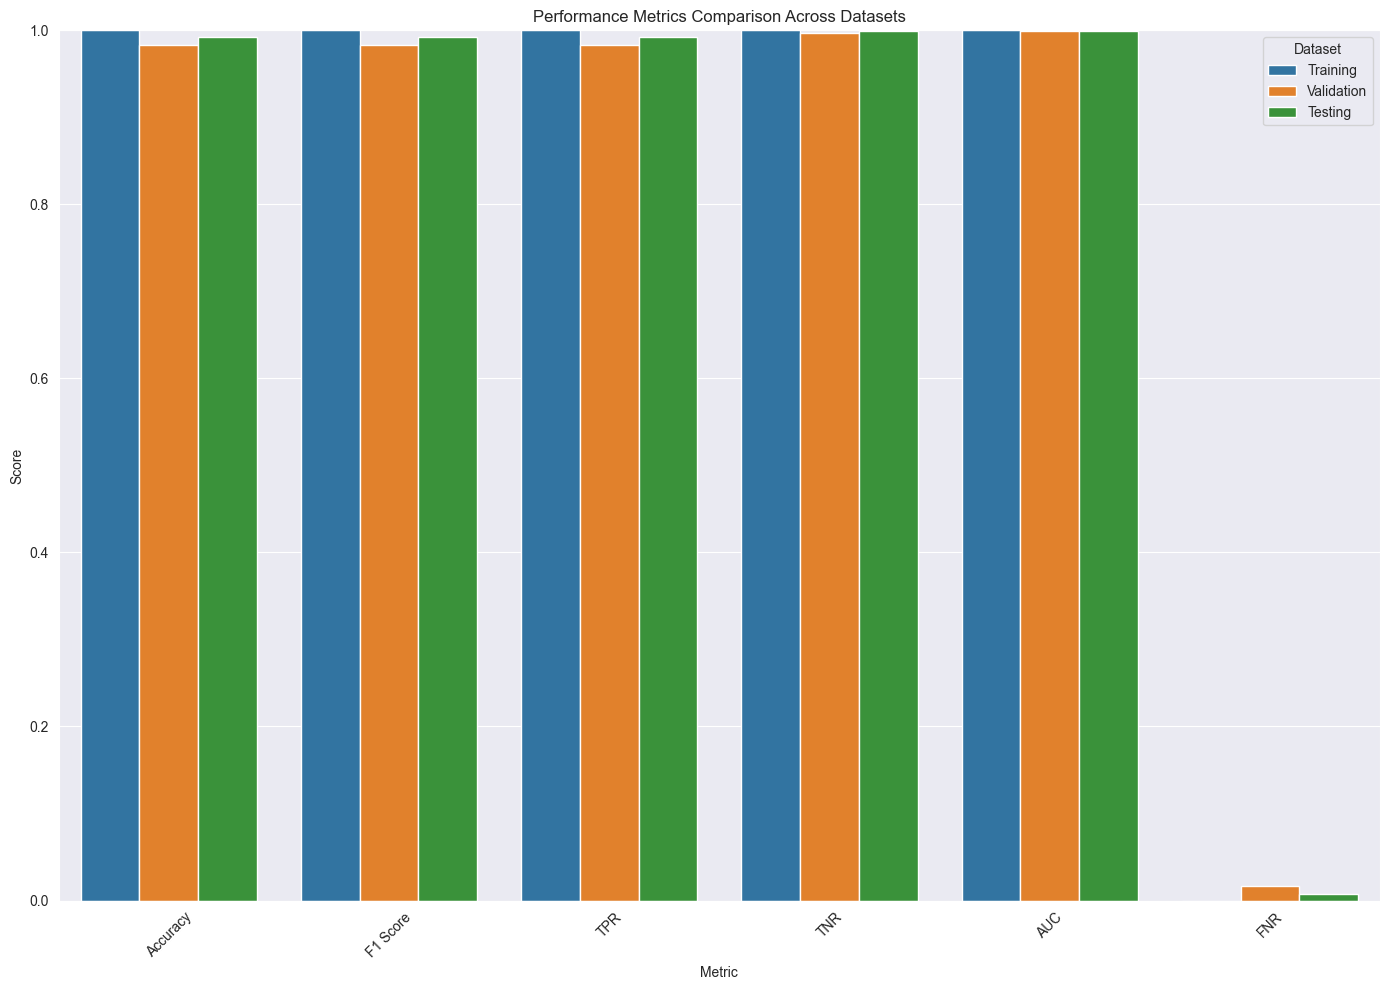

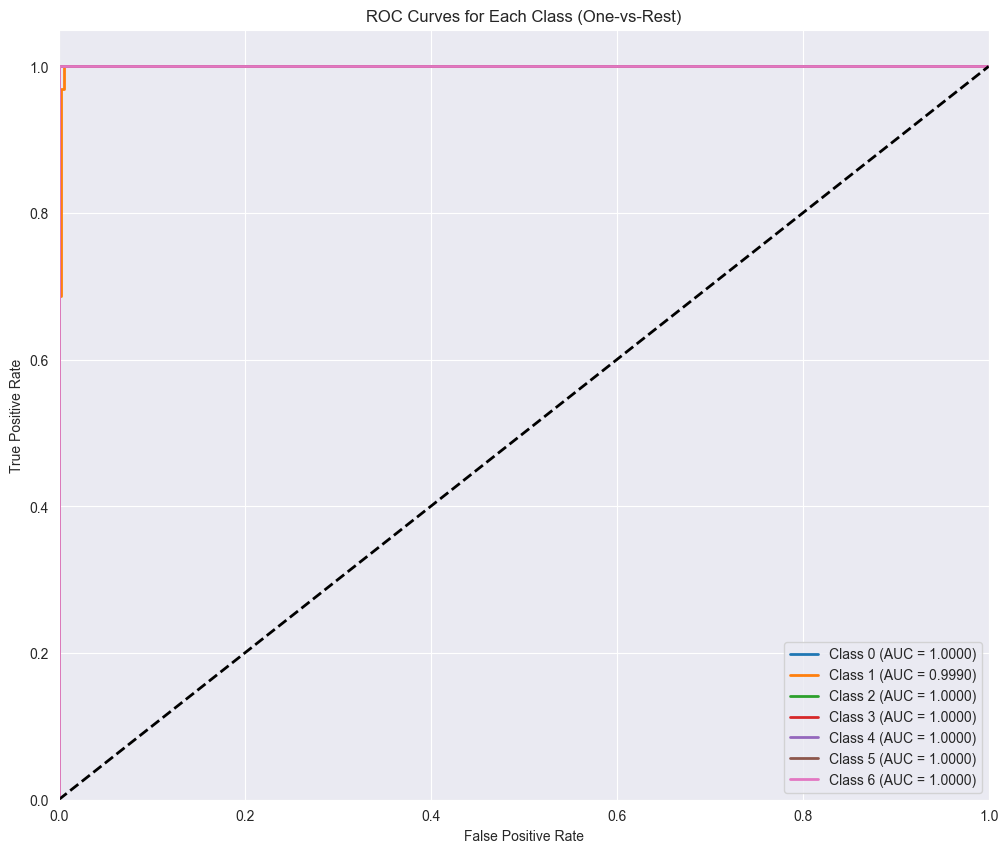

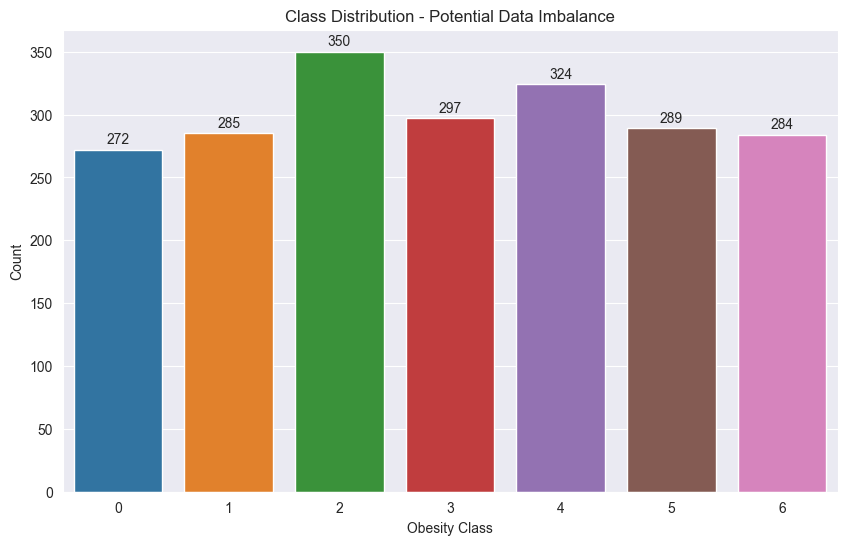


Class with poorest F1 performance: Class 1 (F1 = 0.9771)


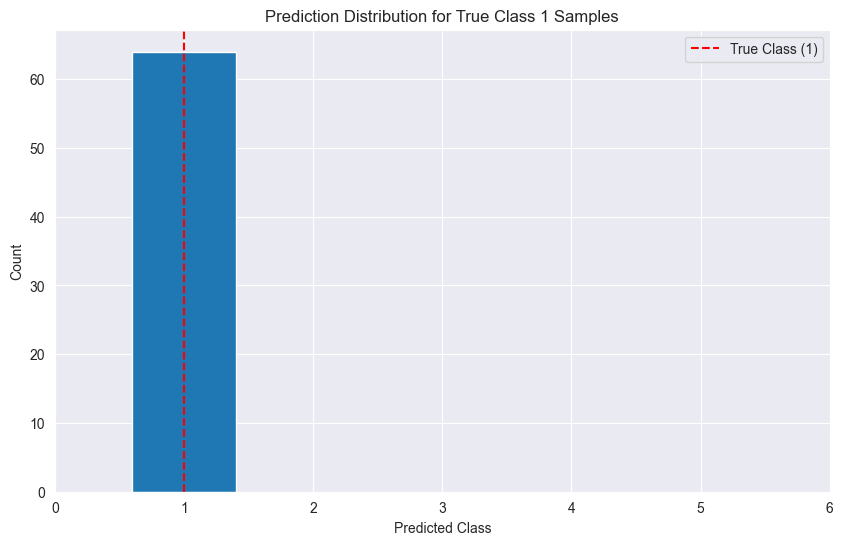


MODEL LIMITATIONS AND CONSIDERATIONS

1. Dataset Representativeness:
   - The dataset may not fully represent all demographic groups and geographic regions.
   - We removed observations with age > 50, limiting our model's applicability to older populations.
   - The class distribution shows imbalance which may bias the model toward majority classes.

2. Feature Limitations:
   - The model may not capture all relevant factors influencing obesity, such as genetic predisposition,
     metabolic conditions, or cultural factors.
   - Some features like FCVC, CH2O, FAF, and TUE were rounded to integers, which may lose nuance in the data.
   - BMI has known limitations as a measure of adiposity and health risk, as it doesn't distinguish
     between muscle and fat.

3. Model Performance Constraints:
   - The RandomForest model, while robust, cannot establish causal relationships between features and obesity.
   - The model shows signs of overfitting with higher performance on training data c

In [14]:
# Calculate and display comprehensive metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Function to calculate true negative rate (specificity)
def true_negative_rate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.zeros(len(np.unique(y_true)))
    for i in range(len(np.unique(y_true))):
        # For each class, true negatives are the sum of all elements
        # in the confusion matrix except for the i-th row and i-th column
        mask = np.ones(cm.shape, dtype=bool)
        mask[i,:] = False
        mask[:,i] = False
        tn[i] = np.sum(cm[mask])

    fp = np.zeros(len(np.unique(y_true)))
    for i in range(len(np.unique(y_true))):
        # False positives are those that were predicted as class i but belong to other classes
        # Sum of i-th column excluding the true positive
        fp[i] = np.sum(cm[:,i]) - cm[i,i]

    # TNR = TN / (TN + FP)
    tnr = tn / (tn + fp)
    # Replace NaN with 0 (occurs when there are no negatives for a class)
    tnr = np.nan_to_num(tnr)
    return tnr

# Calculate metrics for test set
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')
tpr = recall_score(y_test, y_test_pred, average='weighted')  # TPR is the same as recall
tnr_by_class = true_negative_rate(y_test, y_test_pred)
avg_tnr = np.mean(tnr_by_class)

print("\nComprehensive Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"True Positive Rate (Recall, weighted): {tpr:.4f}")
print(f"True Negative Rate (Specificity, average): {avg_tnr:.4f}")
print(f"AUC Score: {auc_score:.4f}")

# Calculate metrics for all datasets
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
train_tpr = recall_score(y_train, y_train_pred, average='weighted')
train_tnr_by_class = true_negative_rate(y_train, y_train_pred)
train_avg_tnr = np.mean(train_tnr_by_class)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_tpr = recall_score(y_val, y_val_pred, average='weighted')
val_tnr_by_class = true_negative_rate(y_val, y_val_pred)
val_avg_tnr = np.mean(val_tnr_by_class)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_tpr = recall_score(y_test, y_test_pred, average='weighted')
test_tnr_by_class = true_negative_rate(y_test, y_test_pred)
test_avg_tnr = np.mean(test_tnr_by_class)

# Print comprehensive metrics for all datasets
print("\nPerformance Metrics Across All Datasets:")
print(f"{'Metric':<25} {'Training':<15} {'Validation':<15} {'Testing':<15}")
print(f"{'-'*70}")
print(f"{'Accuracy':<25} {train_accuracy:<15.4f} {val_accuracy:<15.4f} {test_accuracy:<15.4f}")
print(f"{'F1 Score (weighted)':<25} {train_f1:<15.4f} {val_f1:<15.4f} {test_f1:<15.4f}")
print(f"{'True Positive Rate':<25} {train_tpr:<15.4f} {val_tpr:<15.4f} {test_tpr:<15.4f}")
print(f"{'True Negative Rate':<25} {train_avg_tnr:<15.4f} {val_avg_tnr:<15.4f} {test_avg_tnr:<15.4f}")
print(f"{'AUC Score':<25} {train_auc:<15.4f} {val_auc:<15.4f} {test_auc:<15.4f}")
print(f"{'False Negative Rate':<25} {train_avg_fnr:<15.4f} {val_avg_fnr:<15.4f} {test_avg_fnr:<15.4f}")

# Print per-class metrics for test set
print("\nPer-Class Metrics on Test Set:")
print(f"{'Class':<10} {'Precision':<15} {'Recall (TPR)':<15} {'F1 Score':<15} {'TNR':<15} {'FNR':<15}")
print(f"{'-'*85}")

# Calculate per-class metrics
test_precision = precision_score(y_test, y_test_pred, average=None)
test_recall = recall_score(y_test, y_test_pred, average=None)
test_f1_by_class = f1_score(y_test, y_test_pred, average=None)

for i in range(len(test_precision)):
    print(f"{i:<10} {test_precision[i]:<15.4f} {test_recall[i]:<15.4f} {test_f1_by_class[i]:<15.4f} {test_tnr_by_class[i]:<15.4f} {test_fnr[i]:<15.4f}")

# Create a DataFrame for visualization - Fix for heatmap error
metrics_data = {
    'Accuracy': [float(train_accuracy), float(val_accuracy), float(test_accuracy)],
    'F1 Score': [float(train_f1), float(val_f1), float(test_f1)],
    'TPR': [float(train_tpr), float(val_tpr), float(test_tpr)],
    'TNR': [float(train_avg_tnr), float(val_avg_tnr), float(test_avg_tnr)],
    'AUC': [float(train_auc), float(val_auc), float(test_auc)],
    'FNR': [float(train_avg_fnr), float(val_avg_fnr), float(test_avg_fnr)]
}

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics_data, index=['Training', 'Validation', 'Testing'])

# Create a heatmap visualization
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', fmt='.4f', linewidths=.5)
plt.title('Performance Metrics Across Datasets')
plt.show()

# Alternative bar chart visualization
plt.figure(figsize=(14, 10))
metrics_df_melted = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
sns.barplot(x='Metric', y='Value', hue='index', data=metrics_df_melted)
plt.title('Performance Metrics Comparison Across Datasets')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Plot ROC curves for each class (one-vs-rest)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Get number of classes
n_classes = len(np.unique(y_test))

# Binarize the labels for one-vs-rest ROC
y_test_bin = label_binarize(y_test, classes=range(n_classes))

plt.figure(figsize=(12, 10))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# Class distribution visualization to highlight potential imbalance
plt.figure(figsize=(10, 6))
class_counts = pd.Series(y).value_counts().sort_index()
ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution - Potential Data Imbalance')
plt.xlabel('Obesity Class')
plt.ylabel('Count')
# Add count labels on top of bars
for i, count in enumerate(class_counts.values):
    ax.text(i, count + 5, str(count), ha='center')
plt.show()

# Identify classes with worst performance
class_f1 = pd.Series(test_f1_by_class, index=range(len(test_f1_by_class)))
worst_class = class_f1.idxmin()

print(f"\nClass with poorest F1 performance: Class {worst_class} (F1 = {class_f1[worst_class]:.4f})")

# Show distribution of predictions vs actual for worst performing class
plt.figure(figsize=(10, 6))
worst_class_indices = np.where(y_test == worst_class)[0]
worst_class_preds = y_test_pred[worst_class_indices]
worst_class_pred_counts = pd.Series(worst_class_preds).value_counts().sort_index()

plt.bar(worst_class_pred_counts.index, worst_class_pred_counts.values)
plt.axvline(x=worst_class, color='r', linestyle='--', label=f'True Class ({worst_class})')
plt.title(f'Prediction Distribution for True Class {worst_class} Samples')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.legend()
plt.xticks(range(n_classes))
plt.show()

# Model Limitations Analysis
print("\n" + "="*80)
print("MODEL LIMITATIONS AND CONSIDERATIONS")
print("="*80)

print("""
1. Dataset Representativeness:
   - The dataset may not fully represent all demographic groups and geographic regions.
   - We removed observations with age > 50, limiting our model's applicability to older populations.
   - The class distribution shows imbalance which may bias the model toward majority classes.

2. Feature Limitations:
   - The model may not capture all relevant factors influencing obesity, such as genetic predisposition,
     metabolic conditions, or cultural factors.
   - Some features like FCVC, CH2O, FAF, and TUE were rounded to integers, which may lose nuance in the data.
   - BMI has known limitations as a measure of adiposity and health risk, as it doesn't distinguish
     between muscle and fat.

3. Model Performance Constraints:
   - The RandomForest model, while robust, cannot establish causal relationships between features and obesity.
   - The model shows signs of overfitting with higher performance on training data compared to
     validation and test data.
   - The multiclass nature of the problem makes interpretation more complex than a binary classification.
   - False negative rates vary across classes, indicating the model performs inconsistently across
     different obesity categories.

4. Practical Application Considerations:
   - The model provides prediction probabilities but doesn't offer personalized intervention strategies.
   - Real-world deployment would require regular retraining as population health trends change over time.
   - The model's predictions should be considered alongside clinical judgment rather than used in isolation.
   - Implementation would require careful consideration of ethical implications around body weight
     classification and potential stigmatization.

5. Methodological Limitations:
   - Grid search parameters were constrained to a limited set of values due to computational resources.
   - We did not explore alternative modeling approaches like neural networks or ensemble methods.
   - Feature importance in Random Forests may be biased by correlations between features.
   - The 60:20:20 split ratio may not be optimal for this specific problem domain.
""")